### The goal of this study is to reproduce the results of the paper “Semi-supervised Semantic Segmentation via Strong-weak Dual-branch Network".

### This file contains network definition, training and prediction functions for the dual branch network setup.

# 1.Data Preparation Steps


In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library

# PyTorch libraries:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from typing import Any, Callable, Dict, Optional, Tuple, List
import os

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# fixing randon seeds
torch.manual_seed(501)
random.seed(501)
np.random.seed(501) 

##1.1.Extract Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We extract pre-encoded mask labels which we saved before in the drive, as here. These are mask labels for strong data and weak data.
# They will be used as ground truth in the training 
!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/
!tar -xvf /content/drive/MyDrive/SBDWeak-pre_encoded.tar benchmark_RELEASE/weak_pre_encoded/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
benchmark_RELEASE/weak_pre_encoded/2008_000260.png
benchmark_RELEASE/weak_pre_encoded/2010_005949.png
benchmark_RELEASE/weak_pre_encoded/2009_002626.png
benchmark_RELEASE/weak_pre_encoded/2010_002193.png
benchmark_RELEASE/weak_pre_encoded/2010_001850.png
benchmark_RELEASE/weak_pre_encoded/2008_000941.png
benchmark_RELEASE/weak_pre_encoded/2010_003329.png
benchmark_RELEASE/weak_pre_encoded/2008_001880.png
benchmark_RELEASE/weak_pre_encoded/2008_006400.png
benchmark_RELEASE/weak_pre_encoded/2008_006606.png
benchmark_RELEASE/weak_pre_encoded/2010_002899.png
benchmark_RELEASE/weak_pre_encoded/2008_001402.png
benchmark_RELEASE/weak_pre_encoded/2008_003761.png
benchmark_RELEASE/weak_pre_encoded/2009_004829.png
benchmark_RELEASE/weak_pre_encoded/2010_000564.png
benchmark_RELEASE/weak_pre_encoded/2009_001807.png
benchmark_RELEASE/weak_pre_encoded/2011_002031.png
benchmark_RELEASE/weak_pre_encoded/2008_004770.png
benchmark_RELEASE/weak_pre_encoded/

## 1.2. Import Colab Notebooks

Görüntülenen çıkış son 5000 satıra kısaltıldı.
benchmark_RELEASE/weak_pre_encoded/2010_002193.png
benchmark_RELEASE/weak_pre_encoded/2010_001850.png
benchmark_RELEASE/weak_pre_encoded/2008_000941.png
benchmark_RELEASE/weak_pre_encoded/2010_003329.png
benchmark_RELEASE/weak_pre_encoded/2008_001880.png
benchmark_RELEASE/weak_pre_encoded/2008_006400.png
benchmark_RELEASE/weak_pre_encoded/2008_006606.png
benchmark_RELEASE/weak_pre_encoded/2010_002899.png
benchmark_RELEASE/weak_pre_encoded/2008_001402.png
benchmark_RELEASE/weak_pre_encoded/2008_003761.png
benchmark_RELEASE/weak_pre_encoded/2009_004829.png
benchmark_RELEASE/weak_pre_encoded/2010_000564.png
benchmark_RELEASE/weak_pre_encoded/2009_001807.png
benchmark_RELEASE/weak_pre_encoded/2011_002031.png
benchmark_RELEASE/weak_pre_encoded/2008_004770.png
benchmark_RELEASE/weak_pre_encoded/2009_003173.png
benchmark_RELEASE/weak_pre_encoded/2010_005669.png
benchmark_RELEASE/weak_pre_encoded/2008_002872.png
benchmark_RELEASE/weak_pre_encoded/

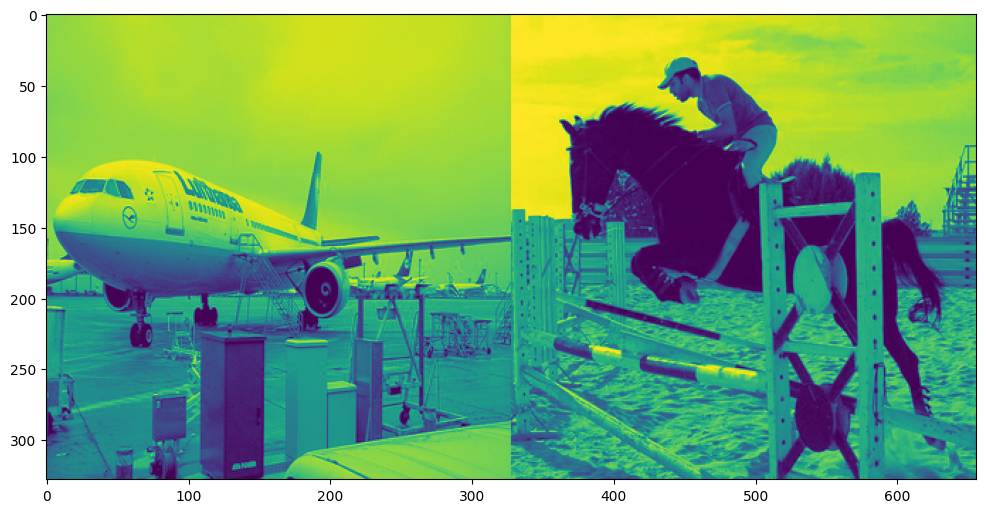

combined_output.shape torch.Size([328, 656, 3])


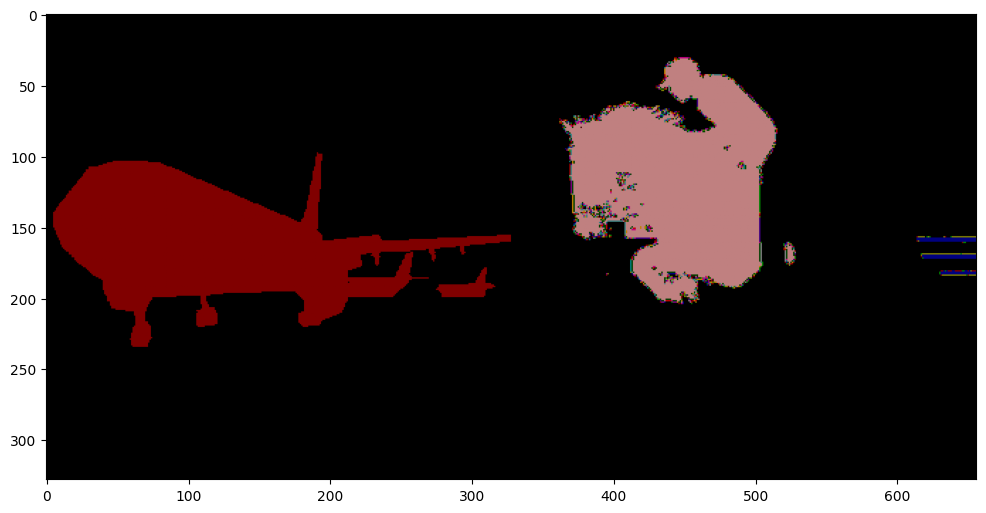

torch.Size([1, 3, 328, 328])
torch.Size([1, 328, 328])


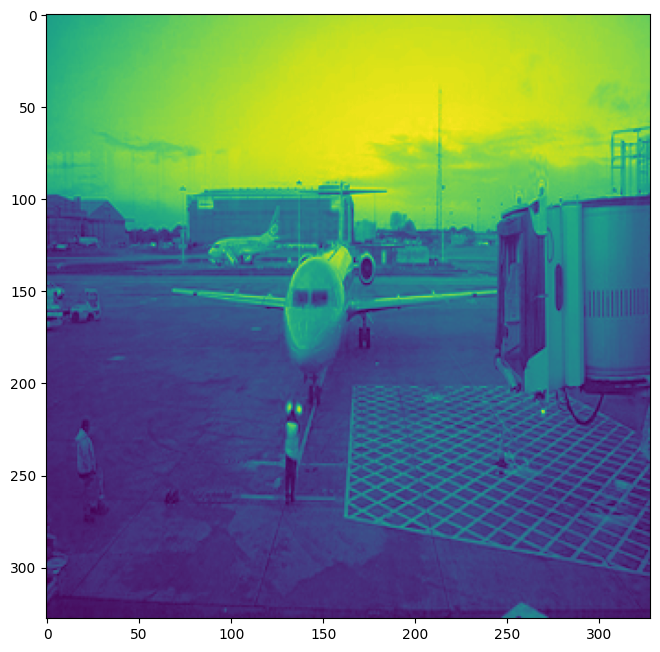

(328, 328)


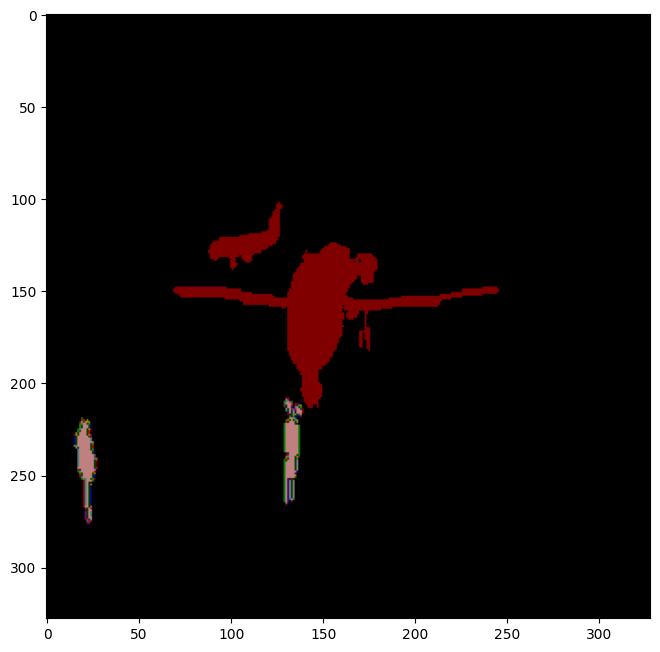

1463
torch.Size([1, 3, 328, 328])
torch.Size([1, 328, 328])


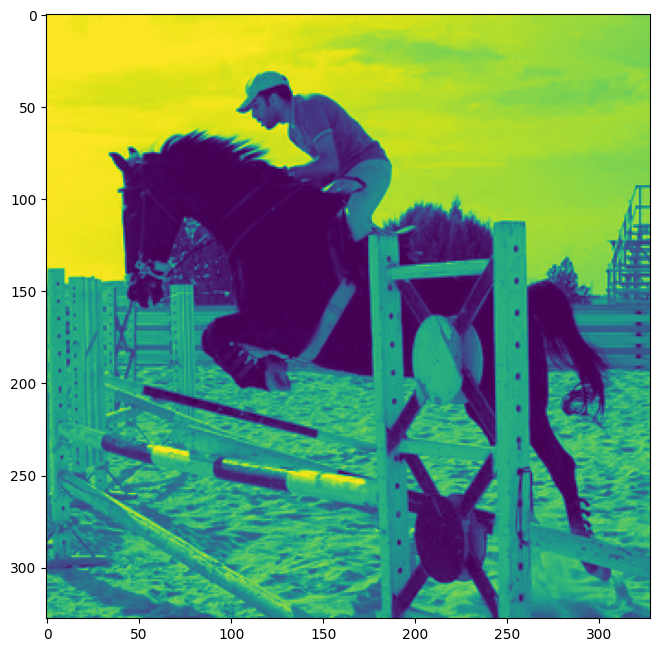

(328, 328)


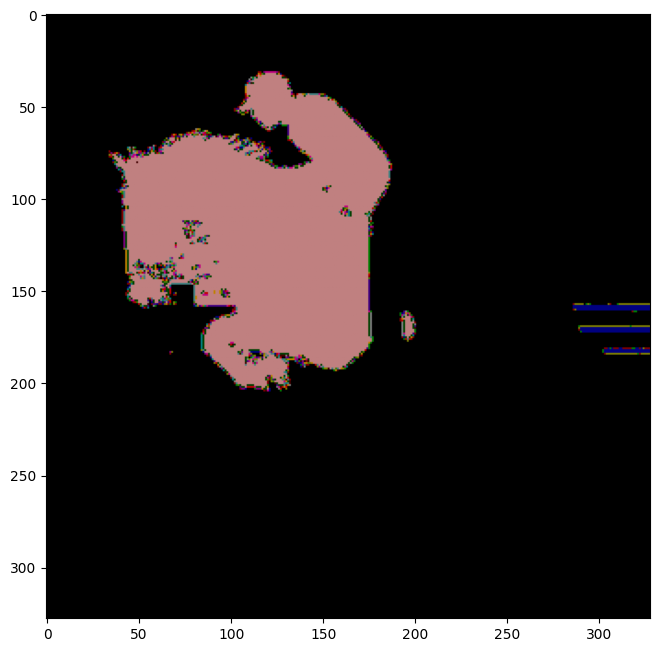

1499


In [ ]:
!cp /content/drive/MyDrive/Datasets.ipynb .
!pip install import-ipynb

import import_ipynb
import Datasets

#print(get_pascal_labels()[1])

## 1.3. Show Data 

In [ ]:
from Datasets import get_pascal_labels
from Datasets import VOCStrongDataset
from Datasets import SBDWeakDataset
from torch.utils.data import Dataset, DataLoader
from Datasets import decode_segmap

inputs shape: torch.Size([1, 3, 328, 656])
targets shape: torch.Size([1, 328, 656])
combined_input.shape torch.Size([328, 656])


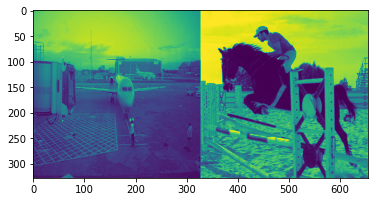

combined_output.shape torch.Size([328, 656, 3])


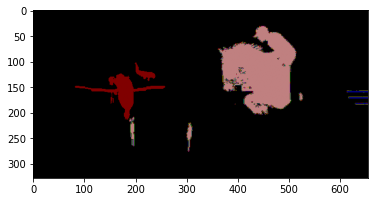

In [ ]:
from torch.utils.data import Dataset, DataLoader
from Datasets import DualNetworkDataset
dataset = DualNetworkDataset(root_strong='VOCdevkit/VOC2012/', 
                                     root_weak='benchmark_RELEASE/', 
                                     is_transform=True,split_strong="train", split_weak="train_noval",img_size=328)
dataloader = DataLoader(dataset)

for i, d in enumerate(dataloader):
  if (i == 0):
    inputs, targets = d
    print('inputs shape:', inputs.shape)
    print('targets shape:', targets.shape)
    combined_input = inputs[0][0]
    print('combined_input.shape', combined_input.shape)
    plt.imshow(combined_input)
    plt.show()
    combined_output = torch.from_numpy(decode_segmap(targets[0].numpy(), plot=False))
    print('combined_output.shape', combined_output.shape)
    
    plt.imshow(combined_output)
    plt.show()

    break

# 2.Network Definition

In [ ]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
from torchvision import models


class DualBranchNetwork(nn.Module):
    def __init__(self):
        
        super(DualBranchNetwork, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)  
        backbone_tmp = models.resnet18(pretrained=True) 
        layers = list(backbone_tmp.children())[:-2]
        self.backbone = nn.Sequential(*layers)
        self.neck = nn.Sequential(
            nn.Conv2d(512, 256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64,kernel_size=3,padding=1),
            nn.ReLU()
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.neck[0].weight)
        torch.nn.init.xavier_uniform_(self.neck[3].weight)
        torch.nn.init.xavier_uniform_(self.neck[5].weight)
            
        self.branch1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(14,14), stride=2, padding=0),
            #nn.ReLU(),
            nn.Conv2d(64, 21, kernel_size=1)
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.branch1[0].weight)
        torch.nn.init.xavier_uniform_(self.branch1[2].weight)
        torch.nn.init.xavier_uniform_(self.branch1[3].weight)
        torch.nn.init.xavier_uniform_(self.branch1[4].weight)
        torch.nn.init.xavier_uniform_(self.branch1[5].weight)
   
                 
        self.branch2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(12,24), stride=2, padding=0),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=(14,14), stride=2, padding=0),
            #nn.ReLU(),
            nn.Conv2d(64, 21, kernel_size=1)
        )
        # initializations
        torch.nn.init.xavier_uniform_(self.branch2[0].weight)
        torch.nn.init.xavier_uniform_(self.branch2[2].weight)
        torch.nn.init.xavier_uniform_(self.branch2[3].weight)
        torch.nn.init.xavier_uniform_(self.branch2[4].weight)
        torch.nn.init.xavier_uniform_(self.branch2[5].weight)
    
    
    def forward(self, x):
    
      x = self.backbone(x)
      x = self.neck(x)       
      x_s = self.branch1(x)
      x_w = self.branch2(x)
      
      return x_s, x_w

In [ ]:
batch_size = 16
model = DualBranchNetwork()
print(summary(model, input_size=(batch_size, 3, 328, 656)))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



Layer (type:depth-idx)                        Output Shape              Param #
DualBranchNetwork                             --                        --
├─Sequential: 1-1                             [16, 512, 11, 21]         --
│    └─Conv2d: 2-1                            [16, 64, 164, 328]        9,408
│    └─BatchNorm2d: 2-2                       [16, 64, 164, 328]        128
│    └─ReLU: 2-3                              [16, 64, 164, 328]        --
│    └─MaxPool2d: 2-4                         [16, 64, 82, 164]         --
│    └─Sequential: 2-5                        [16, 64, 82, 164]         --
│    │    └─BasicBlock: 3-1                   [16, 64, 82, 164]         73,984
│    │    └─BasicBlock: 3-2                   [16, 64, 82, 164]         73,984
│    └─Sequential: 2-6                        [16, 128, 41, 82]         --
│    │    └─BasicBlock: 3-3                   [16, 128, 41, 82]         230,144
│    │    └─BasicBlock: 3-4                   [16, 128, 41, 82]         295,4

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 3.Training

###3.1. DataLoader 

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [ ]:
import Datasets
from Datasets import VOCStrongDataset
from Datasets import SBDWeakDataset
from Datasets import DualNetworkDataset
from torch.utils.data import DataLoader

dual_network_ds = DualNetworkDataset(root_strong='VOCdevkit/VOC2012/', 
                                     root_weak='benchmark_RELEASE/', 
                                     is_transform=True,split_strong="train", split_weak="train_noval",img_size=328)
trainloader = DataLoader(dual_network_ds, batch_size)

###3.2. Training

In [ ]:
def train_dual(model, criterion, optimizer, scheduler, epochs, dataloader, verbose=True):

  loss_history = [] 
  loss_history.append(0.0)
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):   
      if (i % 10 == 0):
        print("Epoch:", epoch, "Iteration:", i, "Last loss:", loss_history[len(loss_history)-1])

      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
  
      labels = labels.to(device)

      print("input shape", inputs.shape)
      print("label shape", labels.shape)
      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs_s, outputs_w = model(inputs)
      
      #outputs_s = outputs_s.cpu()
      #outputs_w = outputs_w.cpu()
      #print("outputs_s shape:", outputs_s.shape)
      #print("outputs_w shape:", outputs_w.shape)
      #strong_tuple = torch.split(outputs_s, 328, dim=3)
      #S_s = strong_tuple[0] # take the first part of the strong branch output 
      #print("strong part shape:", S_s.shape)
      #weak_tuple = torch.split(outputs_w, 328, dim=3)
      #S_w = weak_tuple[1]   # take the second part of the weak branch output
      #print("weak part shape:", S_w.shape)

      outputs = torch.cat((torch.split(outputs_s, 328, dim=3)[0], 
                           torch.split(outputs_w, 328, dim=3)[1]), 
                           dim=3)
      
      #print("outputs shape:", outputs.shape)



      # Calculate loss
      # loss = criterion(outputs.to(device), labels)
      #print("FIRST LOSS=", loss)
      loss = criterion(outputs, labels)
      
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()
      scheduler.step()
      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    #Saving checkpoint after 5 epochs
    if ((epoch+1) % 5 == 0):
      print("End of epoch. Saving epoch data. Epoch:", epoch)
      state = {'epoch': epoch,
               'state_dict': model.state_dict(),
               'optimizer':  optimizer.state_dict(),
               'loss': loss}
             
      file_name = os.path.join('./DualBranch/Training','checkpoint_epoch_{}'.format(epoch+1) + '.pt')
      torch.save(state, file_name)
    
  return loss_history

In [ ]:
# Preparation for training
!mkdir DualBranch
!mkdir DualBranch/Training

#!rm DualBranch/Training/*

In [ ]:
# Loading a checkpoint



In [ ]:
epochs = 1
 # loss function
Centropyloss = torch.nn.CrossEntropyLoss()

# optimizer variable. In the paper authors stated that 'We use Adam optimizer [14] with an initial learning rate of 1e-4
# for the newly-added branches and 5e-6 for the backbone'
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr':5e-5},
                {'params': model.neck.parameters()},
                {'params': model.branch1.parameters(),
                 'params': model.branch2.parameters()}
            ], lr=1e-3, weight_decay=1e-4)

#schedular variable: In the paper authors stated that `The learning rate is decayed by a factor of ten after 12 epochs'
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)
model.to(device)
model.train()
loss_history = train_dual(model, Centropyloss, optimizer, scheduler, epochs, trainloader, verbose=True)

In [ ]:
# clean directory
#!rm DualBranch/Training/*

# print contents of the directory
!ls -al DualBranch/Training

# copy checkpoint file to drive
!cp DualBranch/Training/checkpoint_epoch_20.pt /content/drive/MyDrive/dualbranch_checkpoint_epoch_20_2707.pt

total 868572
drwxr-xr-x 2 root root      4096 Jul 27 19:56 .
drwxr-xr-x 3 root root      4096 Jul 27 17:37 ..
-rw-r--r-- 1 root root 222348093 Jul 27 18:46 checkpoint_epoch_10.pt
-rw-r--r-- 1 root root 222348093 Jul 27 19:21 checkpoint_epoch_15.pt
-rw-r--r-- 1 root root 222348093 Jul 27 19:56 checkpoint_epoch_20.pt
-rw-r--r-- 1 root root 222348093 Jul 27 18:12 checkpoint_epoch_5.pt


In [ ]:
# clean memory
import gc

gc.collect()

torch.cuda.empty_cache()

#4.Visualize the Loss Curve 


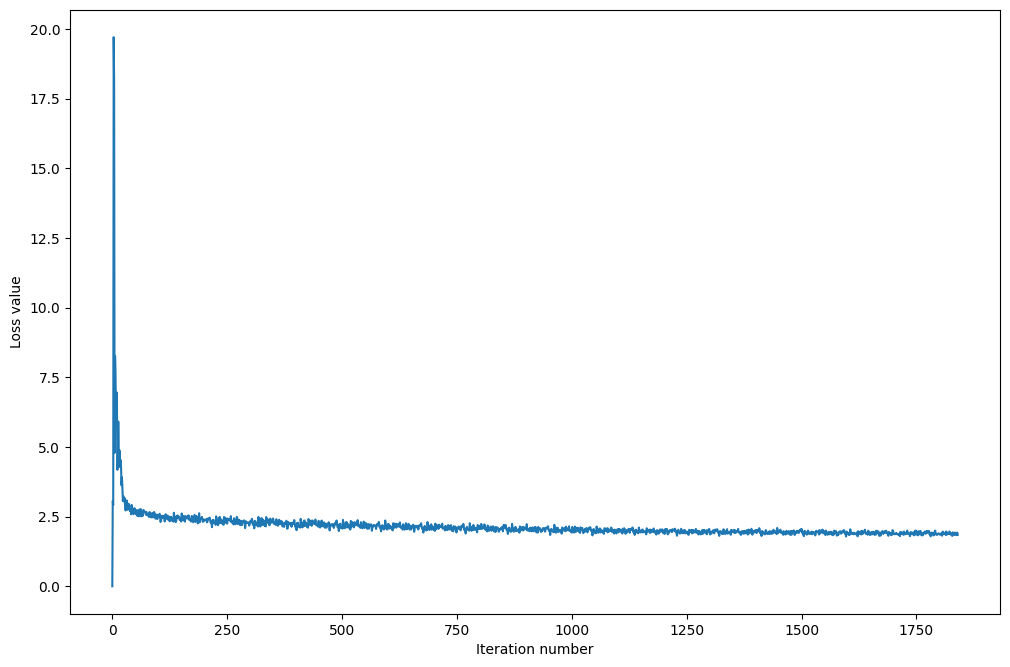

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

# 5.Predicting

###5.1. Loading Checkpoint

In [ ]:
!mkdir DualBranch/Results
!mkdir DualBranch/Results/pred
# copying checkpoint file
!cp /content/drive/MyDrive/dualbranch_checkpoint_epoch_20_2707.pt .

In [ ]:
model= DualBranchNetwork()

# optimizer variable. In the paper authors stated that 'We use Adam optimizer [14] with an initial learning rate of 1e-4
# for the newly-added branches and 5e-6 for the backbone'
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr':5e-6},
                {'params': model.neck.parameters()},
                {'params': model.branch1.parameters(),
                 'params': model.branch2.parameters()}
            ], lr=1e-4, weight_decay=1e-4)

#schedular variable: In the paper authors stated that `The learning rate is decayed by a factor of ten after 12 epochs'
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)
checkpoint = torch.load('./dualbranch_checkpoint_epoch_20_2707.pt')
 
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

###5.2.Predicting with Test Dataset

In [ ]:
batch_size = 16
from Datasets import decode_segmap
from Datasets import DualNetworkDataset
from torch.utils.data import DataLoader

# Importing Image module from PIL package 
from PIL import Image 
import PIL

from os.path import join as pjoin

def predict(model, batch_size, output_path):
  dual_network_ds = DualNetworkDataset(root_strong='VOCdevkit/VOC2012/', 
                                     root_weak='benchmark_RELEASE/', 
                                     is_transform=False, split_strong="val", split_weak="train_noval", img_size=328
                                     )
  testloader = DataLoader(dual_network_ds, batch_size)
  

  correct = 0
  total = 0
  model.eval()
  np.set_printoptions(threshold=np.inf)
  model.to(device)
  with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        outputs_s, outputs_w = model(images)
        # taking first part of the strong branch
        preds = torch.split(outputs_s, 328, dim=3)[0]     
        outputs1 = F.softmax(preds, dim=1)
        outputs_argmax = torch.argmax(outputs1, dim=1)
        
        for j in range(outputs_argmax.shape[0]):
          pred_in = outputs_argmax[j].cpu().numpy()
          pred_arr = decode_segmap(pred_in, plot=False)      
          pred_image = Image.fromarray((pred_arr * 255).astype(np.uint8))
          image_name = dual_network_ds.files_strong[dual_network_ds.split_strong][i*batch_size + j]
          print('Saving ', image_name)
          image_path = pjoin(output_path, image_name + '_pred.png')
          pred_image.save(image_path)
          pred_image.show()

# strong data predict
#predict(model, batch_size, './SingleBranchStrongData/Results/pred')
predict(model, batch_size, './DualBranch/Results/pred')

Saving  2007_000033
Saving  2007_000042
Saving  2007_000061
Saving  2007_000123
Saving  2007_000129
Saving  2007_000175
Saving  2007_000187
Saving  2007_000323
Saving  2007_000332
Saving  2007_000346
Saving  2007_000452
Saving  2007_000464
Saving  2007_000491
Saving  2007_000529
Saving  2007_000559
Saving  2007_000572
Saving  2007_000629
Saving  2007_000636
Saving  2007_000661
Saving  2007_000663
Saving  2007_000676
Saving  2007_000727
Saving  2007_000762
Saving  2007_000783
Saving  2007_000799
Saving  2007_000804
Saving  2007_000830
Saving  2007_000837
Saving  2007_000847
Saving  2007_000862
Saving  2007_000925
Saving  2007_000999
Saving  2007_001154
Saving  2007_001175
Saving  2007_001239
Saving  2007_001284
Saving  2007_001288
Saving  2007_001289
Saving  2007_001299
Saving  2007_001311
Saving  2007_001321
Saving  2007_001377
Saving  2007_001408
Saving  2007_001423
Saving  2007_001430
Saving  2007_001457
Saving  2007_001458
Saving  2007_001526
Saving  2007_001568
Saving  2007_001585


In [ ]:
!rm -rf DualBranch/Results/pred/*

In [ ]:
!tar -cf /content/drive/MyDrive/DualBranch_pred.tar DualBranch/Results/pred